### Exercise 1. 주어진 티커를 이용해 Efficient Frontier를 시각화 하시오

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import risk_models, expected_returns, EfficientFrontier

TICKERS = ['AAPL','GOOGL','XOM','WMT','V','NVDA','JPM','F']
START_DATE = '2010-01-01'
END_DATE = pd.to_datetime('today')

data = yf.download(
    TICKERS, 
    start = START_DATE, 
    end = END_DATE,
    progress = False,
    interval = '1d'
)['Close']

In [3]:
w=np.random.rand(100000, len(TICKERS))
weight_data=[]
for row in w:
    weight_data.append(row/np.sum(row))

weight_df=pd.DataFrame(weight_data)

ret_data=(np.log(data)-np.log(data.shift(1))).dropna()
mu=np.mean(ret_data, axis=0)
sigma=ret_data.cov()
port_mu=[]
port_sigma=[]
for i in range(len(weight_df)):
    port_mu.append( (np.dot(weight_df.iloc[i, :], mu))*252)
    port_sigma.append( np.sqrt( weight_df.iloc[i, :].values @ sigma @ weight_df.iloc[i, :].values) *np.sqrt(252) )


final_data=pd.DataFrame([port_mu, port_sigma]).T
final_data.columns=['mu', 'sigma']

[]

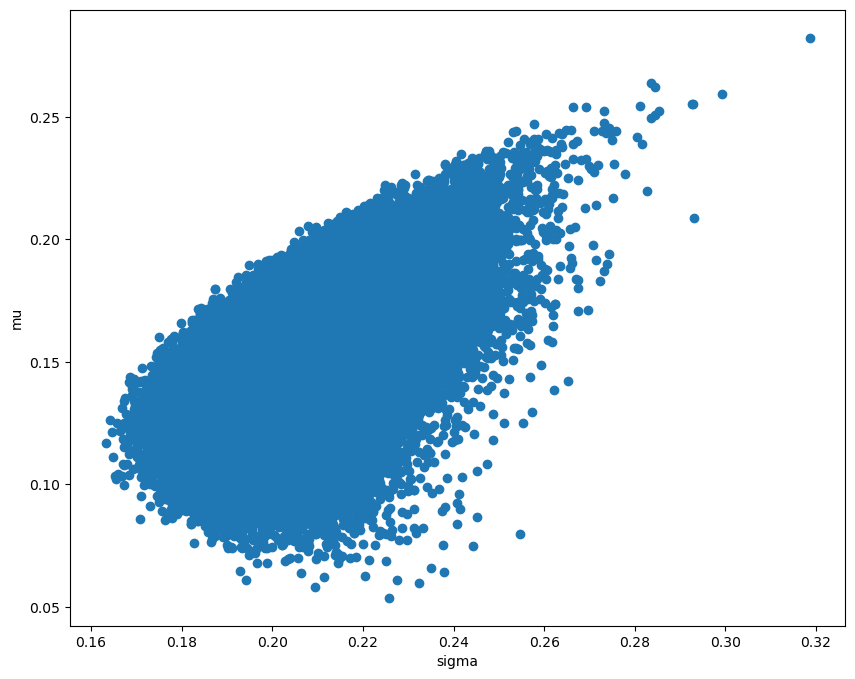

In [4]:
plt.figure(figsize=(10,8))
plt.scatter(final_data.sigma, final_data.mu)
plt.xlabel('sigma')
plt.ylabel('mu')
plt.plot()

### Exercise 2. 주어진 r_f 값을 바탕으로 Capital Allocation Line과 Efficient Frontier를 시각화 하시오

[]

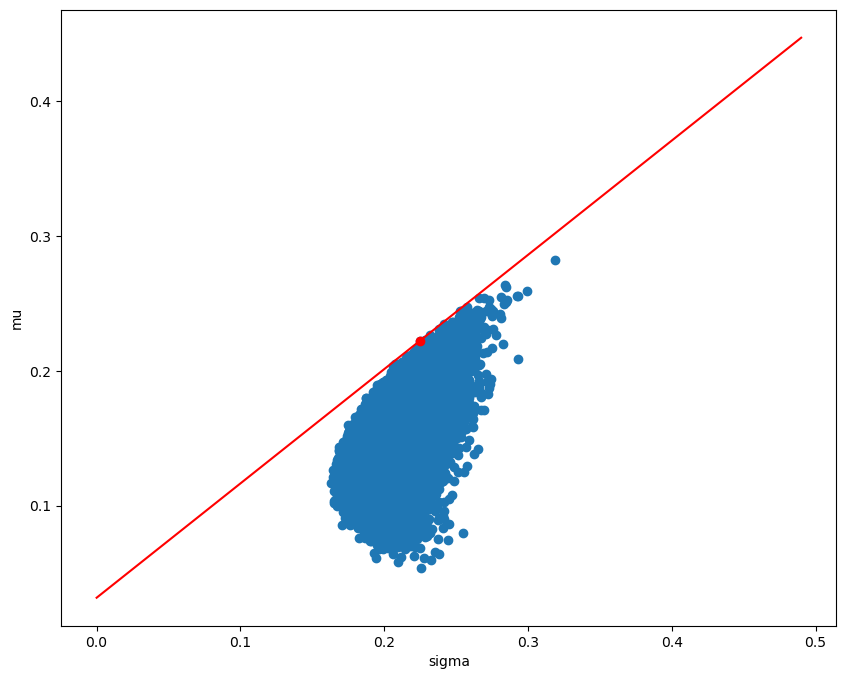

In [5]:
r_f=0.03175

sharpe=(np.subtract(port_mu, r_f))/port_sigma
max_sharpe=np.argmax(sharpe)

x=np.arange(0, 0.5, 0.01)
y=(final_data.mu[max_sharpe]-r_f)*x/final_data.sigma[max_sharpe] + r_f
plt.figure(figsize=(10,8))
plt.scatter(final_data.sigma, final_data.mu)
plt.scatter(final_data.sigma[max_sharpe], final_data.mu[max_sharpe], color='red')
plt.plot(x, y, color='red')
plt.xlabel('sigma')
plt.ylabel('mu')
plt.plot()

### Exercise 3. 주어진 위험회피계수에 대해 위험 포트폴리오의 최적 비율을 구하고, 소비자의 평균-분산 유틸리티 함수와 Capital Allocation Line을 plot하여 그 결과를 확인하시오

[]

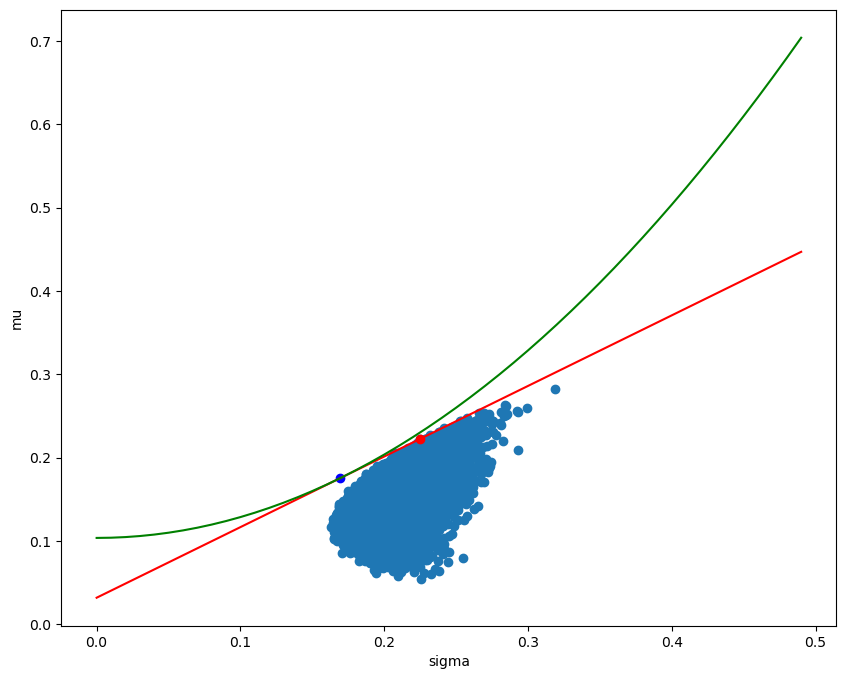

In [22]:
A=5
opt_port= (final_data.mu[max_sharpe]-r_f)/(A*(final_data.sigma[max_sharpe])**2)
y_utility=(A*x**2)/2 + opt_port*final_data.mu[max_sharpe] + (1-opt_port)*r_f - ((A * (final_data.sigma[max_sharpe])**2 * opt_port**2 ) /2)
y_utility

plt.figure(figsize=(10,8))
plt.scatter(final_data.sigma, final_data.mu)
plt.scatter(final_data.sigma[max_sharpe], final_data.mu[max_sharpe], color='red')
plt.scatter(opt_port*final_data.sigma[max_sharpe], opt_port*final_data.mu[max_sharpe]+(1-opt_port)*r_f, color='blue')
plt.plot(x, y, color='red')
plt.plot(x, y_utility, color='green')
plt.xlabel('sigma')
plt.ylabel('mu')
plt.plot()

#### Convex Portfolio Optimization

무위험 이자율을 초과하는 수익률이 기대값 $\mu$와 기대 공분산 $V$를 갖는 $N$개의 보유 자산 포트폴리오를 고려해 보자. Markowitz의 시도는 고전적인 자산 배분 문제를 이차 계획법으로 공식화하는 것이었다.

$$\min_{\omega} \frac{1}{2}\omega^\prime V \omega \text{  subject to } : \omega^\prime a = 1$$

여기서 $a$는 포트폴리오의 제약식을 특정짓는다. 이 문제는 다음과 같은 라그랑지안 형태로 표현할 수 있다.

$$\mathcal{L}\left[\omega, \lambda\right] = \frac{1}{2} \omega^\prime V \omega - \lambda \left( \omega ^ \prime a - 1\right)$$

1계 조건은 다음과 같다.

$$\frac{\partial \mathcal{L}\left[ \omega, \lambda\right]}{\partial \omega} = V \omega - \lambda a$$
$$\frac{\partial \mathcal{L} \left[ \omega, \lambda\right]}{\partial \lambda} = \omega^\prime a - 1$$

1계 조건을 0으로 놓으면 다음을 얻는다.

$$
\begin{align}
V \omega - \lambda a = 0 &\Rightarrow \omega = \lambda V^{-1}a \\
\omega ^ \prime a = a^\prime \omega = 1 &\Rightarrow \lambda a ^\prime V^{-1}a = 1 \Rightarrow \lambda = \frac{1}{a^\prime V^{-1} a}
\end{align}
$$

따라서

$$\omega ^* = \frac{V^{-1}a}{a^\prime V^{-1} a}$$

2계 조건은 이 해가 라그랑지의 최소점이라는 것을 확인한다.

$$
\begin{vmatrix} 
\frac{\partial \mathcal{L}^2(\omega, \lambda)}{\partial \omega^2} 
& \frac{\partial \mathcal{L}^2(\omega, \lambda)}{\partial \omega \partial \lambda}
\\ \frac{\partial \mathcal{L}^2(\omega, \lambda)}{\partial \lambda \partial \omega}
& \frac{\partial \mathcal{L}^2(\omega, \lambda)}{\partial \lambda^2} 
\end{vmatrix} = \begin{vmatrix}
V^\prime & -a^\prime \\
a & 0
\end{vmatrix} = a^\prime a \geq 0
$$

이제 특성 벡터 $a$의 공식을 살펴보자.

1. $a = 1_N$이고, $V = \sigma I_N$인 경우, $\omega^* = \frac{1_N \sigma^{-1}}{N\sigma^{-1}} = \frac{1_N}{N}$이므로 해는 동일 비중 포트폴리오다.
2. $a = 1_N$이고, $V$가 서로 다른 원소를 가진 대각 행렬인 경우 $\omega^* = \frac{1}{\sum_{n=1}^N \frac{1}{V_{n,n}}} \left\{ \frac{1}{V_{n,n}}\right\} _{n = 1, \dots, N}$이므로 해는 역분산 포트폴리오다.
3. $a = 1_N$인 경우 해는 최소 분산 포트폴리오다.
4. $a = \mu$인 경우 해는 포트폴리오의 Sharpe Ratio $\frac{\omega^\prime \mu}{\sqrt{\omega^\prime V \omega}}$을 극대화하며 시장 포트폴리오는 $\frac{V^{-1}\mu}{1_N^\prime V^{-1} \mu}$이다.

#### Condition Number

어떤 공분산 구조는 평균-분산 최적화 해를 불안정하게 만든다. 이유를 이해하고자 공분산 행렬의 조건 수의 개념을 도입해야 한다. 두 증권 간의 상관계수 행렬을 고려하자.

$$C = \begin{bmatrix}
1 & \rho \\
\rho & 1
\end{bmatrix}$$

여기서 $\rho$는 이들 수익률 간의 상관계수이다. 행렬 $C$는 $CW = W\Lambda$로 다음과 같이 대각 행렬화될 수 있다. 먼저 고유값 방정식 $\vert C - I\lambda \vert = 0$으로 놓고, 연산을 하면 다음을 얻는다.

$$\begin{vmatrix} 1 - \lambda & \rho \\ \rho & 1 - \lambda \end{vmatrix} = 0 \Rightarrow \qquad \left( 1 - \lambda \right)^2 - \rho^2 = 0$$ 

이 방정식은 근 $\lambda = 1 \pm \rho$를 가진다. 따라서 $\Lambda$의 대각 원소는 다음과 같다.

$$\Lambda_{1,1} = 1 + \rho$$
$$\Lambda_{2,2} = 1 - \rho$$

둘째, 각 고유값에 연관된 고유 벡터는 다음 연립방정식에 대한 해로 주어진다.

$$\begin{bmatrix} 
1 - \Lambda_{1,1} & \rho \\ 
\rho & 1 - \Lambda_{2,2}
\end{bmatrix} \begin{bmatrix}
W_{1,1} & W_{1,2} \\
W_{2,1} & W_{2,2}
\end{bmatrix} = \begin{bmatrix} 
0 & 0 \\
0 & 0
\end{bmatrix}$$

만약 $C$는 대각 행렬이 아직 아니라면 $\rho \neq 0$이고 이때 연립방정식은 다음 해를 가진다.

$$\begin{bmatrix} 
W_{1,1} & W_{1,2} \\
W_{2,1} & W_{2,2}
\end{bmatrix} = \begin{bmatrix} 
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & - \frac{1}{\sqrt{2}}
\end{bmatrix}$$

그리고 다음을 쉽게 증명할 수 있다.

$$W \Lambda W^\prime = \begin{bmatrix} 
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & - \frac{1}{\sqrt{2}}
\end{bmatrix} \begin{bmatrix} 
1 + \rho & 0 \\
0 & 1 + \rho
\end{bmatrix} \begin{bmatrix} 
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & - \frac{1}{\sqrt{2}}
\end{bmatrix} = \begin{bmatrix} 
1 & \rho \\
\rho & 1 \end{bmatrix}$$

$C$의 대각합은 $\text{tr}(C) = \Lambda_{1,1} + \Lambda_{2,2} = 2$이며, 따라서 $\rho$는 한 고유값이 다른 고유값을 희생해 커질 수 있는가를 설정한다.  $C$의 행렬식은 $\vert C \vert = \Lambda_{1,1} \Lambda_{2,2} = (1 + \rho)(1 - \rho) = 1 - \rho^2$로 주어진다. 행렬식은 $\Lambda_{1,1} = \Lambda_{2,2} = 1$에서 최대값에 도달하며, 이는 상관관계가 없는 경우 $\rho = 0$에 해당한다. 행렬식은 $\Lambda_{1,1} = 0$ 또는 $\Lambda_{2,2} = 0$에서 최소값에 도달하며, 이는 완전 상관관계를 갖는 경우인 $\vert \rho \vert = 1$에 해당한다. $C$의 역행렬은 다음과 같다.

$$C^{-1} = W \Lambda^{-1} W^\prime = \frac{1}{\vert C \vert} \begin{bmatrix}
1 & -\rho \\
-\rho & 1
\end{bmatrix}$$

이는 $\rho$가 0에서 더 벗어날수록 한 고유값이 다른 고유값에 상대적으로 커져 $\vert C \vert$가 0에 접근해 $C^{-1}$이 무한대로 근접한다.

더욱 일반적으로 공분산 구조에 의해 야기된 불안정성을 두 극단적 고유값 간의 크기로 측정될 수 있다. 따라서 공분산 또는 상관 행렬의 조건 수는 최소와 최대 고유값 간의 비율의 절대값으로 정의된다.

$$\lim_{\rho \rightarrow 1^{-}} \frac{\Lambda_{1,1}}{\Lambda_{2,2}} = +\infty$$
$$\lim_{\rho \rightarrow -1^{+}} \frac{\Lambda_{2,2}}{\Lambda_{1,1}} = +\infty$$

In [7]:
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

In [8]:
ef = EfficientFrontier(mu, S)

In [9]:
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

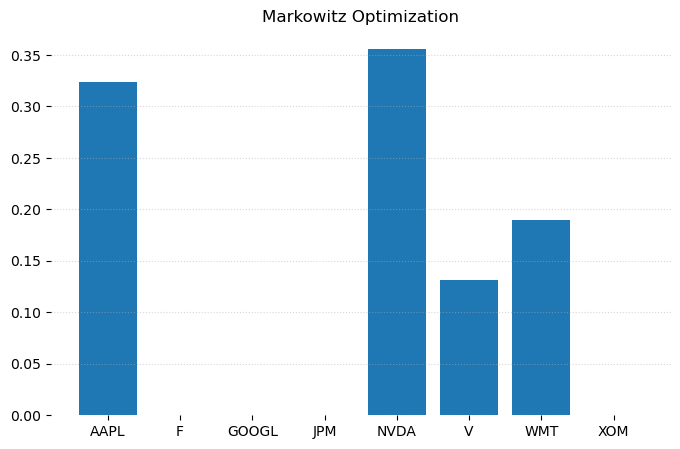

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.bar(
    cleaned_weights.keys(),
    cleaned_weights.values()
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Markowitz Optimization')
plt.show()

#### Markowitz’s Curse

공분산, 상관관계 행렬의 조건수는 최대와 최저 고유값 사이의 비율의 절대값이다. 아래의 그림은 몇 개 상관계수 행렬의 정렬된 고유값을 보여주고 있는데, 조건 수가 각 선의 처음 값과 마지막 값 사이의 비율이다. 이 값은 대각 상관계수 행렬에 대해 최저이며, 그 자체의 역수다. 상관관계를 갖는 상품을 추가할수록 조건 수는 커진다. 어떤 점에서 조건 수는 너무 높아져 수치 오차가 역행렬을 매우 불안정하게 만든다. 어떤 원소의 사소한 변화도 완전히 다른 역행렬을 만들어 버린다. 이것이 바로 마코위츠의 저주이다. 투자 상품들이 더 많이 상관되어 있을수록 분산의 필요성은 더 커지지만, 이때 더욱 불안정한 해법을 얻게 될 가능성이 커진다. 분산의 혜택은 종종 추정 오차에 의해 더 많이 상쇄된다. 

대각 상관계수 행렬은 가장 낮은 조건 수를 가진다. 상관된 상품을 추가할수록 최대 고유값은 더 커지고, 최저 고유값은 더 낮아진다. 조건 수는 빠르게 증가하고 불안정한 역상관계수 행렬을 형성한다. 어떤 점을 넘어서면 분산의 혜택은 추정 오차로 인해 더 많이 상쇄된다.

In [11]:
from tqdm import tqdm

def generate_correlation_matrix(n, matrix_type):
    if matrix_type == "identity":
        return np.eye(n)
    elif matrix_type == "correlated":
        base = np.random.rand(n, n)
        corr = np.dot(base, base.T)
        corr = 0.8 * (corr / np.outer(np.sqrt(np.diag(corr)), np.sqrt(np.diag(corr)))) + 0.2 * np.eye(n)
        # Adjust the first eigenvalue
        eigvals, eigvecs = np.linalg.eigh(corr)
        eigvals[-1] = 1.7  # Set the largest eigenvalue to 1.7
        return eigvecs.dot(np.diag(eigvals)).dot(eigvecs.T)
    elif matrix_type == "ill_conditioned":
        eigvals = np.logspace(np.log10(0.1), np.log10(3.5), n)[::-1]
        Q, _ = np.linalg.qr(np.random.randn(n, n))
        return Q.dot(np.diag(eigvals)).dot(Q.T)
    elif matrix_type == "singular":
        rank = int(n * 0.6)
        A = np.random.randn(n, rank)
        corr = np.dot(A, A.T)
        corr = corr / np.max(np.abs(corr))
        # Adjust the first eigenvalue
        eigvals, eigvecs = np.linalg.eigh(corr)
        eigvals[-1] = 5  # Set the largest eigenvalue to 5
        return eigvecs.dot(np.diag(eigvals)).dot(eigvecs.T)
def calculate_eigenvalues(matrix):
    return np.sort(np.real(np.linalg.eigvals(matrix)))[::-1]

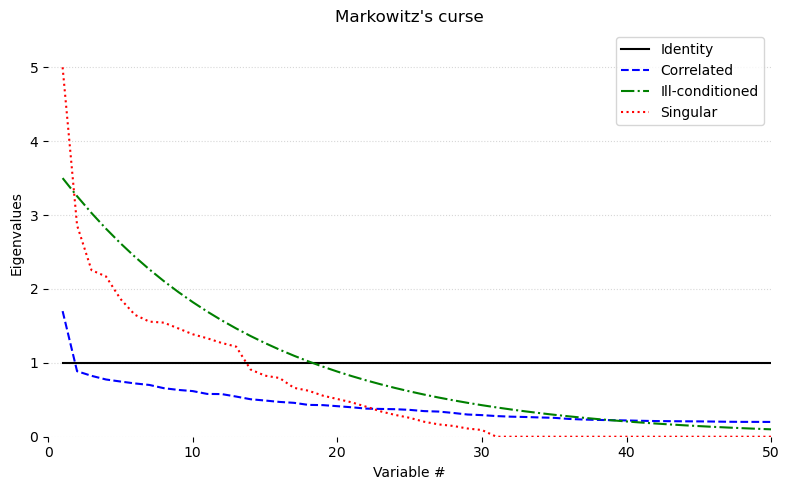

Condition number for identity: 1.00
Condition number for correlated: 8.50
Condition number for ill_conditioned: 35.00
Condition number for singular: -9950342722107230.00


In [12]:
n_variables = 50
matrix_types = ["identity", "correlated", "ill_conditioned", "singular"]
colors = ["black", "blue", "green", "red"]
linestyles = ["-", "--", "-.", ":"]

fig, ax = plt.subplots(figsize = (8, 5))

for mtype, color, style in zip(matrix_types, colors, linestyles):
    corr_matrix = generate_correlation_matrix(n_variables, mtype)
    eigenvalues = calculate_eigenvalues(corr_matrix)
    ax.plot(range(1, n_variables + 1), eigenvalues, color=color, linestyle=style, 
             label=mtype.capitalize().replace("_", "-"))

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xlabel("Variable #")
plt.ylabel("Eigenvalues")
plt.title("Markowitz's curse")
plt.legend()
plt.ylim(0, 5.5)  # Adjusted to show the full range of eigenvalues
plt.xlim(0, n_variables)
plt.tight_layout()
plt.show()

# Print condition numbers
for mtype in matrix_types:
    corr_matrix = generate_correlation_matrix(n_variables, mtype)
    eigenvalues = calculate_eigenvalues(corr_matrix)
    cond_num = np.max(eigenvalues) / np.min(eigenvalues)
    print(f"Condition number for {mtype}: {cond_num:.2f}")
    


공분산의 행렬의 크기를 증가시키면 문제가 더욱 악화될 뿐이다. 각각의 공분산 계수가 더 적은 자유도로 추정되기 때문이다. 일반적으로 특이 행렬이 아닌 크기 $N$의 공분산 행렬을 계산하려면 적어도 $\frac{N(N+1)}{2}$의 독립적이고 동일하게 분포된 관측값이 필요하다. 예를 들어, 크기 50의 공분산 행렬의 역행렬을 구하려면 적어도 5년치의 일별 IID 데이터가 필요하다. 대부분의 투자자들이 알다시피 상관관계 구조가 이런 긴 기간 동안에는 어떠한 합리적 신뢰 수준에서도 변하지 않는 경우는 없다. 이런 문제의 심각함은 단순한 동일가중 포트폴리오가 평균 분산과 리스크 기반의 최적화보다 샘플 외 성과가 더 좋다는 사실로 잘 요약할 수 있다.